In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import json
import numpy as np
import glob
from tqdm import tqdm
import seaborn as sns

First we need to extract useful information from the downloaded chunk of data. 

In [2]:
def process_result(res):
    """
    Given one record the function returns:
    empty list if the reaction was not serious
    list per drug-reaction combination
    list contains:
    unique report id, reaction string, drug indication string, drug category and drug active substance 
    """
    serious = res.get('serious', '2')
    out_list = []

    if serious != '1':
        return out_list
    patient = res['patient']
    patientage = patient.get('patientagegroup', None)
    patientsex = patient.get('patientsex', None)
    drugs = patient.get('drug', [])
    reactions = patient.get('reaction', [])
    all_reactions = [reaction.get('reactionmeddrapt', None) for reaction in reactions]
    added_drugs_names = set()
    for reaction in all_reactions:
        for drug in drugs:
            medprod = drug.get('medicinalproduct', None)
            if medprod in added_drugs_names:
                continue
            if medprod is not None:
                added_drugs_names.add(medprod)
            drugcar = drug.get('drugcharacterization', None)
            drugindication = drug.get('drugindication', None)
            try:
                active_subs = drug['activesubstance']['activesubstancename']
            except:
                active_subs = None
            
            out_list.append(dict(safetyreportid = res['safetyreportid'],
                                 reaction = reaction,
                                 drugind = drugindication,
                                 drugcar = drugcar,
                                 active_subs = active_subs
                                ))
    return out_list 
    
    
def merge_all_files(filenames):
    full_list = []
    for filename in tqdm(filenames):
        try:
            with open(filename) as f:
                data = json.load(f)['results']
        except:
            continue
        for res in data:
            try:
                full_list.extend(process_result(res))
            except Exception as e:
                print(e)
                continue
        del(data)
        
    return full_list

In [3]:
filenames = glob.glob('./data/*.json')
full_list = merge_all_files(filenames)
df = pd.DataFrame(full_list)
df.to_csv('Merged_data.csv')
del(full_list)

100%|█████████████████████████████████████████████████████████████████████████████████| 33/33 [02:10<00:00,  3.96s/it]


In [4]:
df.head()

,safetyreportid,reaction,drugind,drugcar,active_subs
0,18482094,Drug dependence,PRODUCT USED FOR UNKNOWN INDICATION,1,HYDROMORPHONE
1,18482094,Drug dependence,PRODUCT USED FOR UNKNOWN INDICATION,1,FENTANYL
2,18482094,Drug dependence,PRODUCT USED FOR UNKNOWN INDICATION,1,MORPHINE SULFATE
3,18482094,Drug dependence,PRODUCT USED FOR UNKNOWN INDICATION,1,HYDROMORPHONE HYDROCHLORIDE
4,18482094,Drug dependence,PRODUCT USED FOR UNKNOWN INDICATION,1,OXYCODONE HYDROCHLORIDE


In [5]:
df.reaction = df.reaction.str.upper()
df.drugind = df.drugind.str.upper()

In [6]:
df.describe()

,safetyreportid,reaction,drugind,drugcar,active_subs
count,890303,890303,674567,890303,871489
unique,240282,7464,5213,3,5420
top,18673413,DEATH,PRODUCT USED FOR UNKNOWN INDICATION,1,RANITIDINE HYDROCHLORIDE
freq,200,37203,275677,490355,40119


We can notice that there are 800k drug/reaction combinations but onlly ~5k of different active substance and drug indications,  and ~7k of different reactions

##  Check if different disease provoke different reactions

We will assume that drug indication is corresponding to patient disease and use that field instead. 
Let's first check the distributions of different drug indications and reactions.

In [7]:
df_drug_reac = df.loc[df.drugcar=='1', ['drugind', 'reaction']]

In [8]:
unique_pair_counts = df_drug_reac.value_counts().sort_values(ascending=False)

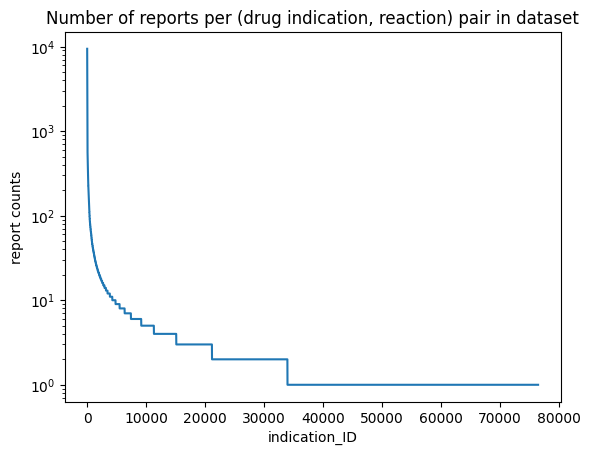

In [9]:
plt.plot(unique_pair_counts.values)
plt.yscale('log')
plt.xlabel('indication_ID')
plt.ylabel('report counts')
plt.title('Number of reports per (drug indication, reaction) pair in dataset');

Let's select drug indication / reaction pairs that have at least 100 occurancies 

In [10]:
represented_pairs = unique_pair_counts[unique_pair_counts>100]
represented_indications = represented_pairs.index.get_level_values('drugind').unique().values
represented_reactions = represented_pairs.index.get_level_values('reaction').unique().values
print('Number of represented indicaions and reactions are ', len(represented_indications), len(represented_reactions))

Number of represented indicaions and reactions are  48 256


In [11]:
represented_indications, represented_reactions[:50]

(array(['PRODUCT USED FOR UNKNOWN INDICATION', 'DYSPEPSIA',
        'GASTROOESOPHAGEAL REFLUX DISEASE', 'COVID-19',
        'RHEUMATOID ARTHRITIS', 'SUICIDE ATTEMPT', 'HIV INFECTION',
        'ABDOMINAL DISCOMFORT', 'PAIN', 'SUSPECTED SUICIDE',
        'HYPERCHLORHYDRIA', 'PLASMA CELL MYELOMA', 'ASTHMA',
        'GASTRIC ULCER', 'COVID-19 PNEUMONIA',
        'PULMONARY ARTERIAL HYPERTENSION', 'MULTIPLE SCLEROSIS',
        'FOETAL EXPOSURE DURING PREGNANCY', 'PARKINSON^S DISEASE',
        'PROSTATE CANCER', 'CHRONIC LYMPHOCYTIC LEUKAEMIA',
        'CONTRACEPTION', 'COLITIS ULCERATIVE',
        'IDIOPATHIC PULMONARY FIBROSIS', 'IMMUNOSUPPRESSANT DRUG THERAPY',
        'BREAST CANCER METASTATIC', 'LUNG NEOPLASM MALIGNANT',
        'CHRONIC MYELOID LEUKAEMIA', 'CROHN^S DISEASE', 'HYPERTENSION',
        'IMMUNOSUPPRESSION', 'PERITONEAL DIALYSIS',
        'PSORIATIC ARTHROPATHY', 'NON-SMALL CELL LUNG CANCER',
        'ACUTE MYELOID LEUKAEMIA', 'DIFFUSE LARGE B-CELL LYMPHOMA',
        'ACUTE 

Product used for unknown reason is very frequent, let's find out what are the most (ab)used drugs

In [12]:
unknown_reas_drugs = df.loc[df.drugind=='PRODUCT USED FOR UNKNOWN INDICATION', 'active_subs'].value_counts().sort_values(ascending=False)

In [13]:
unknown_reas_drugs.head()

OXYCODONE HYDROCHLORIDE                 11470
APIXABAN                                 4721
ACETAMINOPHEN                            4618
ACETAMINOPHEN\HYDROCODONE BITARTRATE     4485
ASPIRIN                                  4167
Name: active_subs, dtype: int64

Text(0.5, 1.0, 'Drugs used for UNKNOWN REASONs')

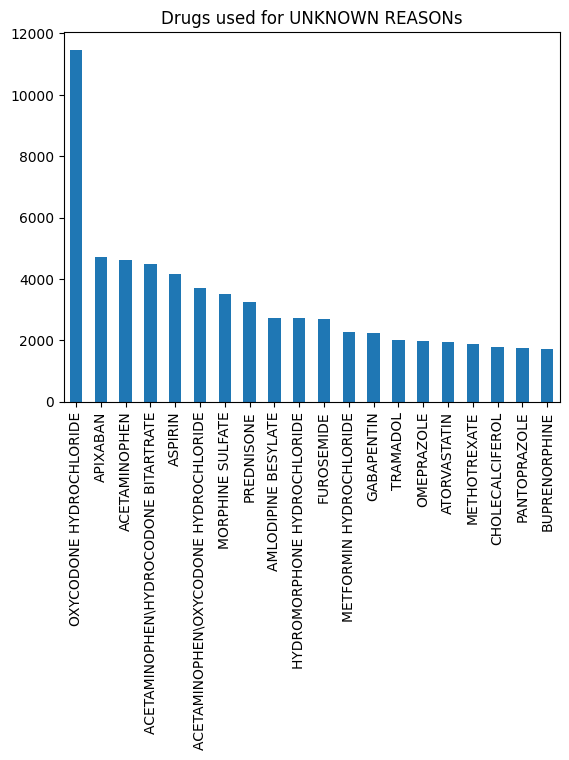

In [14]:
unknown_reas_drugs.iloc[:20].plot(kind='bar')
plt.title('Drugs used for UNKNOWN REASONs')

Seems morphine dominates this distrbution. 

To look for possible correlations between drug indication and reaction lets remove 'wrong usage' indications, as well as reactions that are OFF LABEL USE and DRUG ABUSE and DRUG INEFFECTIVE.
Also let's select only drugs with caracterization 1 - meaning that it is a principal suspect for the reaction

In [15]:
reac_to_remove = ['OFF LABEL USE', 'DRUG ABUSE', 'DRUG INEFFECTIVE']
indic_to_remove = ['PRODUCT USED FOR UNKNOWN INDICATION', 'DRUG DIVERSION']

In [16]:
represented_reactions = [reac for reac in represented_reactions if reac not in reac_to_remove]
represented_indications = [indic for indic in represented_reactions if indic not in indic_to_remove]


mask = (df.drugcar=='1')&(df.reaction.isin(represented_reactions)) \
&(df.drugind.isin(represented_indications))
df_dis_reac = df.loc[mask, ['drugind', 'reaction', 'safetyreportid']]
df_dis_reac_gr = df_dis_reac.groupby(['drugind', 'reaction']).count().reset_index().rename(columns={'safetyreportid':'count'})



/home/marija/miniconda3/envs/data_analysis/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


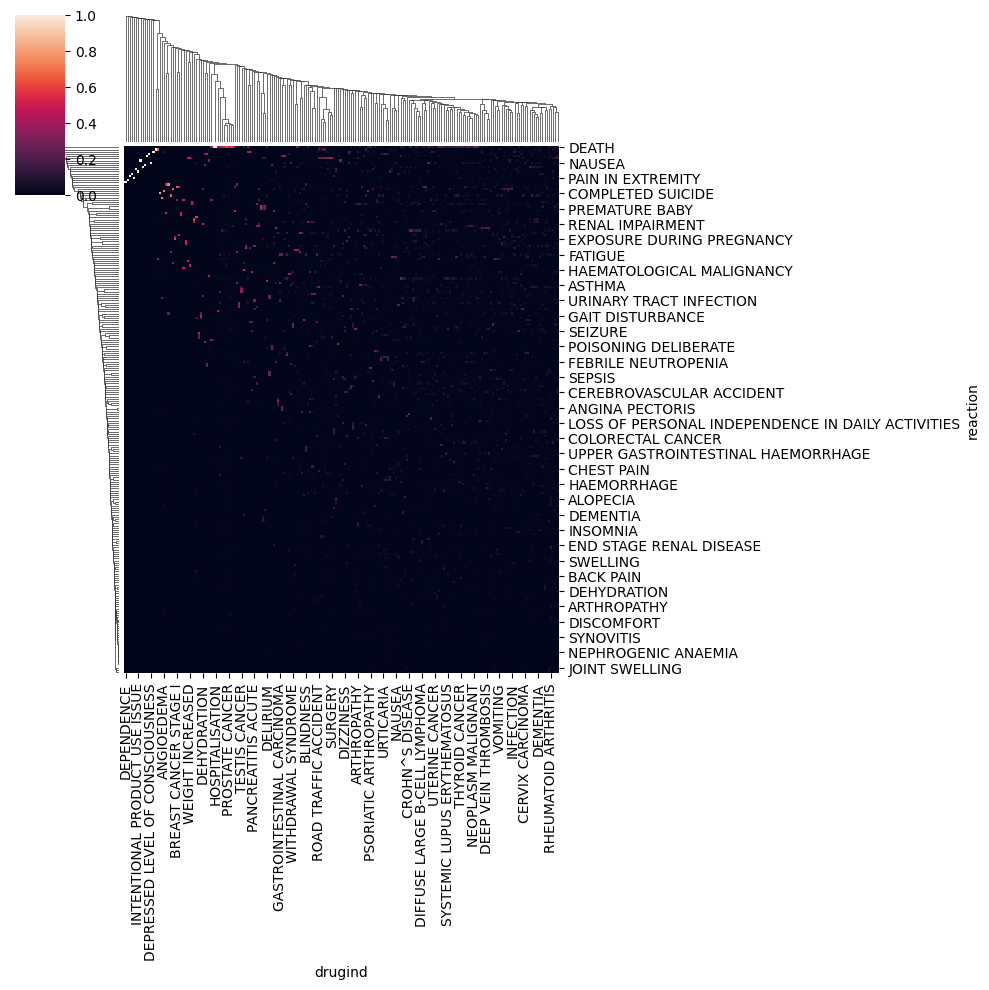

In [17]:
g = df_dis_reac_gr.groupby('drugind', group_keys=False)
g = g.apply(lambda x: x.sort_values('count', ascending=False).head(20))
ev_count_count = pd.crosstab(g.reaction, g.drugind, values=g['count'], aggfunc='sum')
ev_count_count = ev_count_count.fillna(0)
ev_count_count.head()
ev_count_count = ev_count_count/ev_count_count.sum()
sns.clustermap(ev_count_count)

Some reactions are shared between drugs (horizontal stripes on the plot), it would be interesting to try to cluster the diseases based on the associated adverse effects

In [46]:
#now we make a full nreaction x nindications table
drug_reac_matr  = pd.crosstab(df_dis_reac.drugind, df_dis_reac.reaction)
data = drug_reac_matr.values

In [47]:
drug_reac_matr.index

Index(['ABDOMINAL DISCOMFORT', 'ABDOMINAL PAIN', 'ABDOMINAL PAIN UPPER',
       'ACCIDENTAL OVERDOSE', 'ACUTE KIDNEY INJURY', 'ADVERSE DRUG REACTION',
       'ALOPECIA', 'AMNESIA', 'ANAEMIA', 'ANAPHYLACTIC REACTION',
       ...
       'UPPER GASTROINTESTINAL HAEMORRHAGE', 'URINARY TRACT INFECTION',
       'URTICARIA', 'UTERINE CANCER', 'VISUAL IMPAIRMENT', 'VOMITING',
       'WEIGHT DECREASED', 'WEIGHT INCREASED', 'WHEEZING',
       'WITHDRAWAL SYNDROME'],
      dtype='object', name='drugind', length=202)

In [48]:
drug_reac_matr.head(5)

reaction,ABDOMINAL DISCOMFORT,ABDOMINAL PAIN,ABDOMINAL PAIN UPPER,ACCIDENTAL OVERDOSE,ACUTE KIDNEY INJURY,ACUTE LUNG INJURY,ADVERSE DRUG REACTION,ALOPECIA,AMNESIA,ANAEMIA,...,UPPER GASTROINTESTINAL HAEMORRHAGE,URINARY TRACT INFECTION,URTICARIA,UTERINE CANCER,VISUAL IMPAIRMENT,VOMITING,WEIGHT DECREASED,WEIGHT INCREASED,WHEEZING,WITHDRAWAL SYNDROME
drugind,,,,,,,,,,,,,,,,,,,,,
ABDOMINAL DISCOMFORT,2,0,1,0,1,0,0,0,0,0,...,0,0,0,43,0,0,0,0,0,0
ABDOMINAL PAIN,0,4,1,0,0,0,0,0,1,0,...,1,1,2,0,0,0,0,0,0,0
ABDOMINAL PAIN UPPER,1,0,7,0,0,0,0,0,0,1,...,0,0,0,3,0,1,0,0,0,0
ACCIDENTAL OVERDOSE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACUTE KIDNEY INJURY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


We can use reactions counts as features to represent each indication as a vector containing fractions of how often each reaction occures with a given indication. 
To obtain the fractions we can simply divide the row by its sum.

In [51]:
data=data/data.sum(axis=0)
print(data.shape)

(202, 251)


Since the data is high-dimensional we can first use some dimensionality reduction tehnique before passing it through a clustering algorythm.

In [104]:
from umap import UMAP
embeddings = UMAP(n_neighbors=10, min_dist=0.0, n_components=2, random_state=42).fit_transform(data)

import hdbscan
labels = hdbscan.HDBSCAN(
    min_cluster_size=3,
).fit_predict(embeddings)

unique_labs = np.unique(labels)
unique_labs

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18])

In [105]:
embeddings.shape

(202, 2)

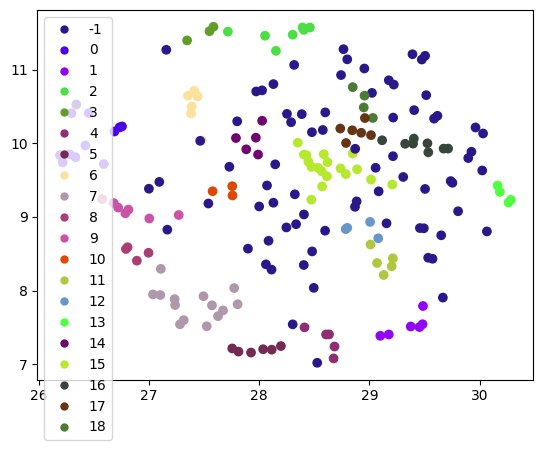

In [106]:
from matplotlib.lines import Line2D
colors_labels = {lab:np.random.rand(3,) for lab in unique_labs}

fig, ax = plt.subplots()
custom = [Line2D([], [], marker='.', markersize=10, color=color, linestyle='None') for color in colors_labels.values()]
scatter = ax.scatter(embeddings[:, 0], embeddings[:, 1], c=[colors_labels[l] for l in labels])

ax.legend(custom, list(colors_labels.keys()), loc='upper left', fontsize=10)


In [107]:
for lab in unique_labs:
    if (lab==-1):
        continue
    clustered = drug_reac_matr[labels==lab].index.values
    if len(clustered)<20:
        print(clustered, '\n')


['ALOPECIA' 'CEREBROVASCULAR ACCIDENT' 'CONSTIPATION' 'DEMENTIA'
 'DEPRESSION' 'DRUG WITHDRAWAL SYNDROME' 'INSOMNIA'
 'LOWER RESPIRATORY TRACT INFECTION' 'LUNG DISORDER' 'MEDICATION ERROR'
 'SOMNOLENCE'] 

['ATRIAL FIBRILLATION' 'CARDIAC DISORDER' 'DEEP VEIN THROMBOSIS'
 'OESOPHAGEAL CARCINOMA' 'PANCREATIC CARCINOMA' 'PULMONARY EMBOLISM'] 

['HYPOTENSION' 'INTENTIONAL OVERDOSE' 'INTENTIONAL PRODUCT MISUSE'
 'POISONING DELIBERATE' 'SUICIDAL IDEATION' 'SUICIDE ATTEMPT'
 'TOXICITY TO VARIOUS AGENTS'] 

['BACK PAIN' 'CARDIAC ARREST' 'INJURY'] 

['ABDOMINAL DISCOMFORT' 'BLADDER CANCER' 'BRAIN NEOPLASM MALIGNANT'
 'BREAST CANCER STAGE II' 'MALIGNANT NEOPLASM PROGRESSION'] 

['BREAST CANCER' 'DIFFUSE LARGE B-CELL LYMPHOMA' 'GASTRIC CANCER'
 'LUNG NEOPLASM MALIGNANT' 'OVARIAN CANCER' 'PLASMA CELL MYELOMA'] 

['DRUG REACTION WITH EOSINOPHILIA AND SYSTEMIC SYMPTOMS'
 'EXPOSURE DURING PREGNANCY' 'FOETAL EXPOSURE DURING PREGNANCY'
 'GASTROINTESTINAL DISORDER' 'HEADACHE' 'SURGERY'] 

['CARDIAC FAIL

Some of the clusters do make sense (for example back pain and injury are in the same cluster, some cancers grouped together etc). 

The result (and conclusion) could possibly be improved with better statistics and data preprocessing and/or more carefully chosen dimensionality reduction/ clustering algorithm. 



## Drug - reaction correlation

It is tempting to try to answer if some reaction was induced by some drug. Note that even to estimate correlation we would need: how many times  the drug provokes no adverse effect and, hence, is not in this database; and how many times the effects happens spontaniously (without taking any drugs). 

Seems that one way to 'hint' drug correlation to the adverse event is to look for PRR- Proportional Reporting Ratio (FDA whitepaper). PRR compares ratio of the effect among all the effects excluding the drug in question, and the ratio of the effect when the drug was taken over all the effects recorded for the same drug.
Here, the assumption is that the database is diverse enough to estimate the spontanious adverse effect unrelated to any drugs. That might not hold if there are overrepresentations of certain drugs/reactions.

To ensure statistics we will only look into drugs and reactions that have sufficient representation in the database and take sqrt(N) of a broad estimate of the 'sufficient representation'.

In [77]:
min_statistics = np.sqrt(len(df))
print(min_statistics)

943.558689218641


Number of sufficiently represented drugs is 222


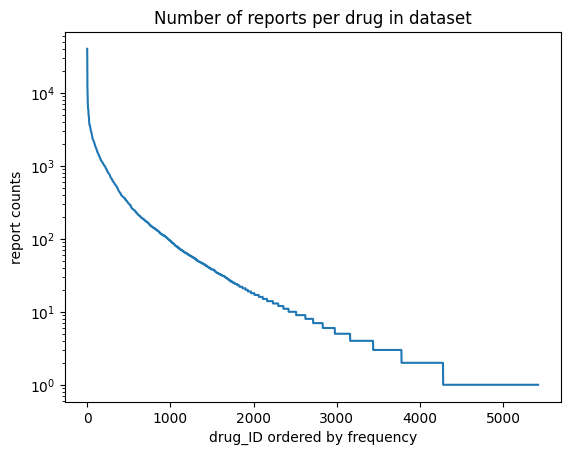

In [78]:
unique_act = df['active_subs'].value_counts().sort_values(ascending=False)
plt.plot(unique_act.values)
plt.yscale('log')
plt.xlabel('drug_ID ordered by frequency')
plt.ylabel('report counts')
plt.title('Number of reports per drug in dataset');
represented_drugs = unique_act[unique_act>min_statistics]
print(f'Number of sufficiently represented drugs is {len(represented_drugs)}')

Number of sufficiently represented reactions is 182


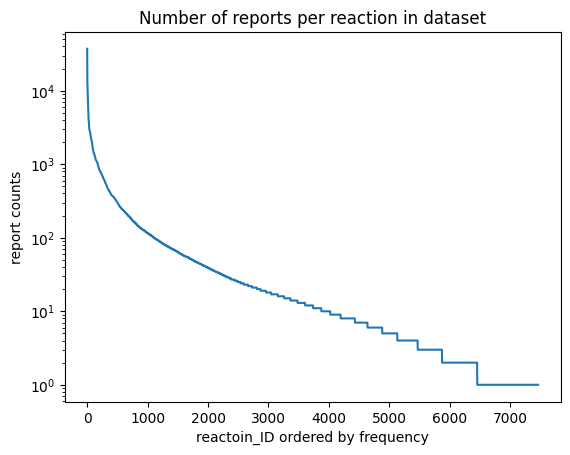

In [79]:
unique_reac = df['reaction'].value_counts().sort_values(ascending=False)
plt.plot(unique_reac.values)
plt.yscale('log')
plt.xlabel('reactoin_ID ordered by frequency')
plt.ylabel('report counts')
plt.title('Number of reports per reaction in dataset');
represented_reactions = unique_reac[unique_reac>min_statistics]
print(f'Number of sufficiently represented reactions is {len(represented_reactions)}')

In [80]:
count_per_reaction = df.groupby('reaction')['safetyreportid'].count()
count_per_reaction.name = 'react_count'
count_per_drug = df.groupby('active_subs')['safetyreportid'].count()
count_per_drug.name = 'drug_count'

In [81]:
df_reac_drug = df[['reaction', 'active_subs', 'safetyreportid']].groupby(['reaction', 'active_subs']).count().reset_index()

In [82]:
df_reac_drug = df_reac_drug.merge(count_per_drug, left_on='active_subs', right_index=True)
df_reac_drug = df_reac_drug.merge(count_per_reaction, left_on='reaction', right_index=True)

In [83]:
df_reac_drug.head()

,reaction,active_subs,safetyreportid,drug_count,react_count
0,ABDOMINAL ABSCESS,ABATACEPT,1,2758,89
1,ABDOMINAL ABSCESS,ACETAMINOPHEN,1,11337,89
2,ABDOMINAL ABSCESS,ADALIMUMAB,2,8567,89
3,ABDOMINAL ABSCESS,AMITRIPTYLINE,1,1358,89
4,ABDOMINAL ABSCESS,ATEZOLIZUMAB,1,1011,89


In [84]:
df_reac_drug = df_reac_drug.assign(drug_frac = df_reac_drug.safetyreportid/df_reac_drug.drug_count,
                    reac_frac = (df_reac_drug.react_count-df_reac_drug.safetyreportid)/(len(df)-df_reac_drug.react_count-df_reac_drug.drug_count+df_reac_drug.safetyreportid))

In [85]:
#lets select only drugs/reaction that are decided to be representative
df_reac_drug = df_reac_drug[df_reac_drug.reaction.isin(represented_reactions.index.values)&df_reac_drug.active_subs.isin(represented_drugs.index.values)]
df_reac_drug = df_reac_drug.assign(PRR=df_reac_drug.drug_frac/df_reac_drug.reac_frac)

In [86]:
df_relRPP = df_reac_drug[df_reac_drug.PRR>1]

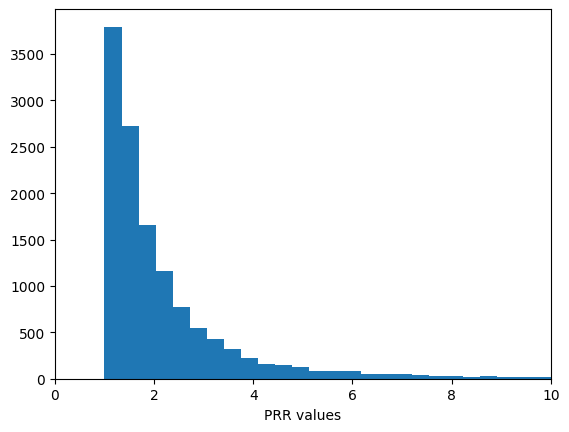

In [87]:
plt.hist(df_relRPP.PRR, bins=300);
plt.xlim(0, 10)
plt.xlabel('PRR values');

We can visualize some effects of couple of known (to me) drugs. We will use RPP field as importance of the word

In [88]:
from wordcloud import WordCloud

    
def plot_wordclout_for_drug(df, drugname):
    word_dict = df_relRPP.loc[df_relRPP['active_subs']==drugname, ['reaction', 'PRR']].set_index('reaction').to_dict()['PRR']
    wc = WordCloud(background_color="white",width=1000,height=1000, max_words=50,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(word_dict)
    plt.imshow(wc)
    plt.axis('off')
    plt.title(drugname, fontsize=30)
    plt.show()
    

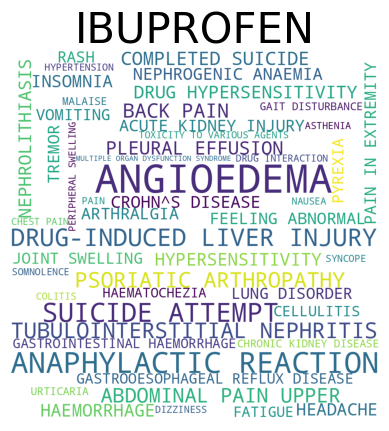

In [89]:
plot_wordclout_for_drug(df_relRPP, 'IBUPROFEN')

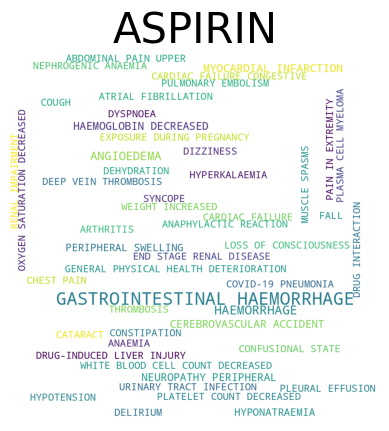

In [90]:
plot_wordclout_for_drug(df_relRPP, 'ASPIRIN')

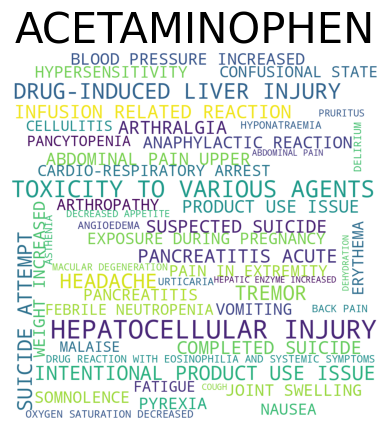

In [91]:
plot_wordclout_for_drug(df_relRPP, 'ACETAMINOPHEN')

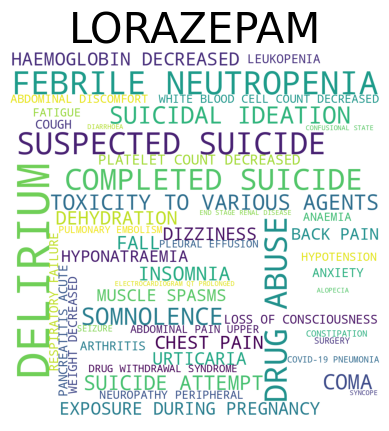

In [92]:
plot_wordclout_for_drug(df_relRPP, 'LORAZEPAM')

Let's use this information in a very naive way - to recommend possible alternatives for a given indication that have less adverse effects. For each drug indication we will get a list of possible active substances. We remove those that are ending either in DEATH or related to SUICIDE (randomly chosen bad adverse effects)
This is just a toy application since:
1. the way we calculated relevant effects can suffer from data biases
2. we could, the most, establish correlation, not causality
3. the drug possible alternatives does not depend only on its indication 

In [93]:
df_relRPP.reaction.unique()

array(['ABDOMINAL DISCOMFORT', 'ABDOMINAL PAIN', 'ABDOMINAL PAIN UPPER',
       'ACUTE KIDNEY INJURY', 'ALOPECIA', 'ANAEMIA',
       'ANAPHYLACTIC REACTION', 'ANGIOEDEMA', 'ANXIETY', 'ARTHRALGIA',
       'ARTHRITIS', 'ARTHROPATHY', 'ASTHENIA', 'ASTHMA',
       'ATRIAL FIBRILLATION', 'BACK PAIN', 'BLADDER CANCER',
       'BLOOD PRESSURE INCREASED', 'BONE DENSITY DECREASED',
       'BREAST CANCER', 'CARDIAC DISORDER', 'CARDIAC FAILURE',
       'CARDIAC FAILURE CONGESTIVE', 'CARDIO-RESPIRATORY ARREST',
       'CATARACT', 'CELLULITIS', 'CEREBROVASCULAR ACCIDENT', 'CHEST PAIN',
       'COLITIS', 'COLITIS ULCERATIVE', 'COMA', 'CONDITION AGGRAVATED',
       'CONFUSIONAL STATE', 'CONSTIPATION',
       'CONTRAINDICATED PRODUCT ADMINISTERED', 'COUGH', 'COVID-19',
       'COVID-19 PNEUMONIA', 'CROHN^S DISEASE', 'DEATH',
       'DEEP VEIN THROMBOSIS', 'DELIRIUM', 'DEPRESSION',
       'DIABETES MELLITUS', 'DIARRHOEA', 'DISABILITY',
       'DISEASE PROGRESSION', 'DIZZINESS', 'DRUG DEPENDENCE',
     

In [94]:

drugs_to_avoid = df_relRPP.groupby('active_subs')['reaction'].apply(lambda x:any(x.isin(['DEATH', 'COMPLETED SUICIDE','SUICIDE ATTEMPT', 'SUSPECTED SUICIDE' ])))
drugs_to_avoid = drugs_to_avoid[drugs_to_avoid]


In [95]:
df_drug_ind = df[['active_subs', 'drugind']].dropna()
df_drug_ind = df_drug_ind[~df_drug_ind.drugind.isin(['PRODUCT USED FOR UNKNOWN INDICATION', 'DRUG ABUSE', 'WRONG DRUG'])]

In [96]:

df_drug_ind = df_drug_ind.assign(drug_avoid = df_drug_ind.active_subs.isin(drugs_to_avoid.index))


In [97]:
def split_drugs_list(dfp):
    drugs = dfp.active_subs
    mask = dfp.drug_avoid
    goods = drugs.values[mask.values]
    bads = drugs.values[~mask.values]
    return [goods, bads]

In [98]:
df_drug_ind = df_drug_ind.groupby('drugind').apply(lambda x:split_drugs_list(x))

In [99]:
disease = 'COVID-19'
print('recommended drugs \n', df_drug_ind[disease][0])
print('not recommended drugs \n', df_drug_ind[disease][1])


recommended drugs 
 ['CIPROFLOXACIN' 'ASCORBIC ACID' 'ACYCLOVIR' 'IBUPROFEN' 'LISINOPRIL'
 'ALBUTEROL' 'CIPROFLOXACIN' 'SECUKINUMAB' 'ALBUTEROL' 'VITAMINS'
 'VITAMINS' 'VITAMINS' 'VITAMINS' 'VITAMINS' 'ASCORBIC ACID' 'APIXABAN'
 'VITAMINS' 'CLOPIDOGREL BISULFATE' 'VITAMINS' 'APIXABAN' 'VITAMINS'
 'UNSPECIFIED INGREDIENT' 'ASCORBIC ACID' 'AMOXICILLIN' 'ASPIRIN'
 'NAPROXEN' 'FUROSEMIDE' 'ACETAMINOPHEN' 'ASPIRIN' 'ASPIRIN' 'ASPIRIN'
 'UNSPECIFIED INGREDIENT' 'ACETAMINOPHEN' 'CIPROFLOXACIN'
 'UNSPECIFIED INGREDIENT' 'OMEPRAZOLE' 'CIPROFLOXACIN' 'TAMSULOSIN'
 'PANTOPRAZOLE' 'ASCORBIC ACID' 'ASPIRIN' 'ACETAMINOPHEN'
 'UNSPECIFIED INGREDIENT' 'ACYCLOVIR' 'VITAMINS' 'VITAMINS'
 'ASCORBIC ACID' 'VITAMINS' 'UNSPECIFIED INGREDIENT' 'CIPROFLOXACIN'
 'ACETAMINOPHEN' 'CLOPIDOGREL BISULFATE' 'MAGNESIUM' 'PANTOPRAZOLE'
 'UNSPECIFIED INGREDIENT' 'ASPIRIN' 'PANTOPRAZOLE' 'WARFARIN'
 'RUXOLITINIB' 'SPIRONOLACTONE' 'HYDROXYZINE HYDROCHLORIDE' 'AMOXICILLIN'
 'VITAMIN D NOS' 'OMEPRAZOLE' 'UNSPECIFIED INGRED